In [48]:
import os
import sys
import gc
#from torch import cuda
import acorn.core
print(acorn.core.__file__)

import numpy as np
import pandas as pd
import scipy.sparse as sps
import yaml
from itertools import chain, product, combinations
import torch

from time import time as tt
from tqdm import tqdm
import wandb
from acorn.stages.data_reading import AthenaReader
from acorn.core.infer_stage import infer
from acorn.core.eval_stage import evaluate

from acorn.stages.data_reading.models.trackml_utils import *

from acorn.stages.data_reading.data_reading_stage import EventReader
from acorn.stages.data_reading.models.trackml_reader import TrackMLReader

from acorn.stages.graph_construction.models.metric_learning import MetricLearning
from acorn.stages.edge_classifier.models.filter import Filter
from acorn.stages.edge_classifier import InteractionGNN
from acorn.stages.edge_classifier.edge_classifier_stage import EdgeClassifierStage

from acorn.stages.graph_construction.utils import handle_weighting
from acorn.stages.graph_construction.models.utils import graph_intersection, build_edges
from acorn.stages.graph_construction.utils import *
from acorn.stages.graph_construction.models.py_module_map import PyModuleMap
from acorn.stages.graph_construction.graph_construction_stage import GraphConstructionStage

from acorn.utils import handle_hard_node_cuts

from acorn.stages.track_building import utils 
from torch_geometric.utils import to_scipy_sparse_matrix

#run = wandb.init(project=model_gnn.hparams["project"], entity='gnnproject')

/global/u2/a/alazar/acorn_new/acorn/core/__init__.py


In [49]:
confidr = "../../examples/Example_1/data_reader.yaml"
configmm = "../../examples/Example_1/module_map_infer.yaml"
configGnn = "../../examples/Example_1/gnn_infer.yaml"
configGnn_eval = "../../examples/Example_1/gnn_eval.yaml"
configTbi = "../../examples/Example_1/track_building_infer.yaml"
configTbe = "../../examples/Example_1/track_building_eval.yaml"

In [50]:
gnn_dir = "/pscratch/sd/a/alazar/cf/Example_1/module_map/"
gnn_val = os.path.join(gnn_dir, "valset")
all_events = [event for event in os.listdir(gnn_val) if event.endswith(".pyg")]
all_events = sorted(all_events)
event0 = torch.load(os.path.join(gnn_val, all_events[0]))
event1 = torch.load(os.path.join(gnn_val, all_events[1]))

In [51]:
all_events

['event000000102.pyg',
 'event000000108.pyg',
 'event000000123.pyg',
 'event000000126.pyg',
 'event000000130.pyg',
 'event000000153.pyg',
 'event000000154.pyg',
 'event000000176.pyg',
 'event000000190.pyg',
 'event000000191.pyg']

In [52]:
print(event0.edge_index.shape, event1.edge_index.shape)

torch.Size([2, 1003135]) torch.Size([2, 1543967])


In [53]:
#handle_hard_cuts(event0, {"pt": [1000, np.inf]})

In [54]:
event0

Data(norm_y_1=[278183], eta=[278183], hit_id=[278183], eta_angle_2=[278183], cluster_x_2=[278183], phi_angle_1=[278183], phi_angle_2=[278183], eta_angle_1=[278183], module_id=[278183], z=[278183], norm_z_2=[278183], norm_y_2=[278183], norm_z_1=[278183], norm_x_1=[278183], cluster_z_2=[278183], cluster_x_1=[278183], x=[278183], cluster_y_2=[278183], y=[1003135], phi=[278183], region=[278183], cluster_y_1=[278183], cluster_z_1=[278183], norm_x_2=[278183], r=[278183], track_edges=[2, 115280], nhits=[115280], primary=[115280], radius=[115280], particle_id=[115280], pdgId=[115280], pt=[115280], config=[1], event_id='000000102', edge_index=[2, 1003135], truth_map=[115280])

In [55]:
event0.event_id, event1.event_id

('000000102', '000000108')

In [56]:
tracking_dir = "/pscratch/sd/a/alazar/cf/Example_1/connected_components"
tracking_val = os.path.join(tracking_dir, "valset")
all_events = os.listdir(tracking_val)
event0 = torch.load(os.path.join(tracking_val, all_events[0]))
event1 = torch.load(os.path.join(tracking_val, all_events[1]))

In [57]:
event0.event_id, event1.event_id

(['000000123'], ['000000191'])

In [58]:
print(event0.edge_index.shape, event1.edge_index.shape)

torch.Size([2, 34880]) torch.Size([2, 37923])


In [59]:
print((event0.scores > 0.8).sum(), (event1.scores > 0.8).sum())

tensor(13799) tensor(14260)


In [60]:
handle_hard_node_cuts

<function acorn.utils.loading_utils.handle_hard_node_cuts(event, hard_cuts_config)>

In [61]:
#infer(configGnn,checkpoint=config_gnn['stage_dir']+'artifacts/best-4l0jlwuh-val_loss=0.085163-epoch=77.ckpt')

 10%|█         | 1/10 [00:00<00:02,  3.69it/s]

['000000102']
['000000108']


 30%|███       | 3/10 [00:00<00:01,  4.98it/s]

['000000123']
['000000126']


 50%|█████     | 5/10 [00:01<00:01,  4.70it/s]

['000000130']


 60%|██████    | 6/10 [00:01<00:00,  4.37it/s]

['000000153']
['000000154']


 80%|████████  | 8/10 [00:01<00:00,  5.29it/s]

['000000176']


 90%|█████████ | 9/10 [00:01<00:00,  4.68it/s]

['000000190']
['000000191']


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]
/global/u2/a/alazar/acorn_new/acorn/stages/track_building/utils.py:225: RuntimeWarning: invalid value encountered in log10
  np.log10(varconf["x_lim"][0]), np.log10(varconf["x_lim"][1]), 10
/global/u2/a/alazar/acorn_new/acorn/utils/plotting_utils.py:39: RuntimeWarning: invalid value encountered in long_scalars
  average = passed / total
/global/homes/a/alazar/.conda/envs/gnn4itk_a/lib/python3.9/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Number of reconstructed particles: 11653
Number of particles: 11926
Number of matched tracks: 14816
Number of tracks: 14924
Number of duplicate reconstructed particles: 1265
Efficiency: 0.977
Fake rate: 0.007
Duplication rate: 0.109


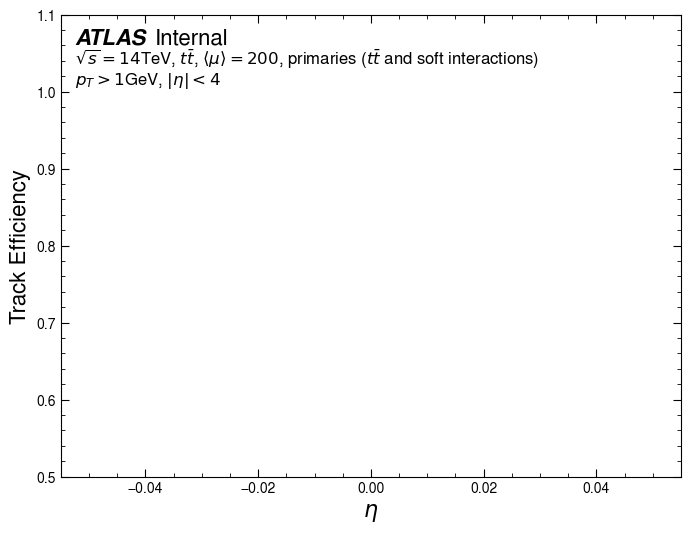

In [62]:
evaluate(configTbe,None,dataset="valset")

In [63]:
with open("../../examples/Example_1/module_map_infer.yaml", "r") as f:
    config_mm = yaml.load(f, Loader=yaml.FullLoader)
model_mm = PyModuleMap(config_mm)
#model_mm.setup(stage="predict")
model_mm.load_module_map()
model_mm.load_data("/pscratch/sd/a/alazar/cf/Example_1/feature_store/")

Loaded 0 training events, 10 validation events and 0 testing events


In [64]:
with open("../../examples/Example_1/gnn_train.yaml", "r") as f:
    config_gnn = yaml.load(f, Loader=yaml.FullLoader)
model_gnn = InteractionGNN(config_gnn)
model_gnn.setup('predict')
model_gnn = InteractionGNN.load_from_checkpoint(config_gnn['stage_dir']+'artifacts/best-4l0jlwuh-val_loss=0.085163-epoch=77.ckpt')
#dataloaders_gnn = model_gnn.predict_dataloader()

config_tbe = yaml.safe_load(open("../../examples/Example_1/track_building_eval.yaml", "r"))
print(config_gnn['stage_dir']+'artifacts')

/global/u2/a/alazar/acorn_new/acorn/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [particle_id] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn_new/acorn/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [nhits] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn_new/acorn/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [primary] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn_new/acorn/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [pdgId] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn_new/acorn/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [ghost] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn_new/acorn/utils/loading_utils.py:78:

Defining figures of merit
/pscratch/sd/a/alazar/cf/Example_1/gnn/artifacts


/global/u2/a/alazar/acorn_new/acorn/stages/edge_classifier/edge_classifier_stage.py:96: UserWarning: Failed to define figures of merit, due to logger unavailable
  warnings.warn(


In [65]:
def evaluate_labelled_graphs(graphset, config):
    all_y_truth, all_pt  = [], []
    evaluated_events = [
        utils.evaluate_labelled_graph(
            event,
            sel_conf=config["target_tracks"],
            matching_fraction=config["matching_fraction"],
            matching_style=config["matching_style"],
            min_track_length=config["min_track_length"],
        )
        for event in tqdm(graphset)
    ]
    evaluated_events = pd.concat(evaluated_events)

    particles = evaluated_events[evaluated_events["is_reconstructable"]]
    reconstructed_particles = particles[particles["is_reconstructed"] & particles["is_matchable"]]
    tracks = evaluated_events[evaluated_events["is_matchable"]]
    matched_tracks = tracks[tracks["is_matched"]]

    n_particles = len(particles.drop_duplicates(subset=['event_id', 'particle_id']))
    n_reconstructed_particles = len(reconstructed_particles.drop_duplicates(subset=['event_id', 'particle_id']))

    n_tracks = len(tracks.drop_duplicates(subset=['event_id', 'track_id']))
    n_matched_tracks = len(matched_tracks.drop_duplicates(subset=['event_id', 'track_id']))

    n_dup_reconstructed_particles = len(reconstructed_particles) - n_reconstructed_particles

    print(f"Number of reconstructed particles: {n_reconstructed_particles}")
    print(f"Number of particles: {n_particles}")
    print(f"Number of matched tracks: {n_matched_tracks}")
    print(f"Number of tracks: {n_tracks}")
    print(f"Number of duplicate reconstructed particles: {n_dup_reconstructed_particles}")   

    # Plot the results across pT and eta
    eff = n_reconstructed_particles / n_particles
    fake_rate = 1 - (n_matched_tracks / n_tracks)
    dup_rate = n_dup_reconstructed_particles / n_reconstructed_particles

    logging.info(f"Efficiency: {eff:.3f}")
    logging.info(f"Fake rate: {fake_rate:.3f}")
    logging.info(f"Duplication rate: {dup_rate:.3f}")
    print(f"Efficiency: {eff:.3f}")
    print(f"Fake rate: {fake_rate:.3f}")
    print(f"Duplication rate: {dup_rate:.3f}")

In [66]:
def make_result_summary(
    n_reconstructed_particles,
    n_particles,
    n_matched_tracks,
    n_tracks,
    n_dup_reconstructed_particles,
    eff,
    fake_rate,
    dup_rate,
):
    summary = f"Number of reconstructed particles: {n_reconstructed_particles}\n"
    summary += f"Number of particles: {n_particles}\n"
    summary += f"Number of matched tracks: {n_matched_tracks}\n"
    summary += f"Number of tracks: {n_tracks}\n"
    summary += (
        "Number of duplicate reconstructed particles:"
        f" {n_dup_reconstructed_particles}\n"
    )
    summary += f"Efficiency: {eff:.3f}\n"
    summary += f"Fake rate: {fake_rate:.3f}\n"
    summary += f"Duplication rate: {dup_rate:.3f}\n"

    return summary


def tracking_efficiency(dataset, config): #plot_config,
    """
    Plot the track efficiency vs. pT of the edge.
    """
    all_y_truth, all_pt = [], []
    #dataset = getattr(self, config["dataset"])

    evaluated_events = []
    for event in tqdm(dataset):
        evaluated_events.append(
            utils.evaluate_labelled_graph(
                event,
                matching_fraction=config["matching_fraction"],
                matching_style=config["matching_style"],
                sel_conf=config["target_tracks"],
                min_track_length=config["min_track_length"],
            )
        )

    evaluated_events = pd.concat(evaluated_events)

    particles = evaluated_events[evaluated_events["is_reconstructable"]]
    reconstructed_particles = particles[
        particles["is_reconstructed"] & particles["is_matchable"]
    ]
    tracks = evaluated_events[evaluated_events["is_matchable"]]
    matched_tracks = tracks[tracks["is_matched"]]

    n_particles = len(particles.drop_duplicates(subset=["event_id", "particle_id"]))
    n_reconstructed_particles = len(
        reconstructed_particles.drop_duplicates(subset=["event_id", "particle_id"])
    )

    n_tracks = len(tracks.drop_duplicates(subset=["event_id", "track_id"]))
    n_matched_tracks = len(
        matched_tracks.drop_duplicates(subset=["event_id", "track_id"])
    )

    n_dup_reconstructed_particles = (
        len(reconstructed_particles) - n_reconstructed_particles
    )

    eff = n_reconstructed_particles / n_particles
    fake_rate = 1 - (n_matched_tracks / n_tracks)
    dup_rate = n_dup_reconstructed_particles / n_reconstructed_particles

    result_summary = make_result_summary(
        n_reconstructed_particles,
        n_particles,
        n_matched_tracks,
        n_tracks,
        n_dup_reconstructed_particles,
        eff,
        fake_rate,
        dup_rate,
    )

    print(f"Number of reconstructed particles: {n_reconstructed_particles}")
    print(f"Number of particles: {n_particles}")
    print(f"Number of matched tracks: {n_matched_tracks}")
    print(f"Number of tracks: {n_tracks}")
    print(f"Number of duplicate reconstructed particles: {n_dup_reconstructed_particles}")   
    print(f"Efficiency: {eff:.3f}")
    print(f"Fake rate: {fake_rate:.3f}")
    print(f"Duplication rate: {dup_rate:.3f}")

    #self.log.info("Result Summary :\n\n" + result_summary)

    # res_fname = os.path.join(
    #     self.hparams["stage_dir"],
    #     f"results_summary_{self.hparams['matching_style']}.txt",
    # )

    # with open(res_fname, "w") as f:
    #     f.write(result_summary)

    # First get the list of particles without duplicates
    grouped_reco_particles = particles.groupby("particle_id")[
        "is_reconstructed"
    ].any()
    # particles["is_reconstructed"] = particles["particle_id"].isin(grouped_reco_particles[grouped_reco_particles].index.values)
    particles.loc[
        particles["particle_id"].isin(
            grouped_reco_particles[grouped_reco_particles].index.values
        ),
        "is_reconstructed",
    ] = True
    particles = particles.drop_duplicates(subset=["particle_id"])

    # Plot the results across pT and eta (if provided in conf file)
    #os.makedirs(self.hparams["stage_dir"], exist_ok=True)

    # for var, varconf in plot_config["variables"].items():
    #     utils.plot_eff(
    #         particles,
    #         var,
    #         varconf,
    #         save_path=os.path.join(
    #             self.hparams["stage_dir"],
    #             f"track_reconstruction_eff_vs_{var}_{self.hparams['matching_style']}.png",
    #         ),
    #     )

In [67]:
with open(configTbi, 'r') as f:
    config_tbi = yaml.full_load(f)

In [78]:
from torch import cuda
device ='cuda'
cur_allocated_mem = {}
cur_cached_mem = {}
max_allocated_mem = {}
max_cached_mem = {}
i=0

model_mm = model_mm.to("cuda")
model_gnn = model_gnn.to("cuda")

# cur_allocated_mem[i] = cuda.memory_allocated(i)
# cur_cached_mem[i] = cuda.memory_reserved(i)
# max_allocated_mem[i] = cuda.max_memory_allocated(i)
# max_cached_mem[i] = cuda.max_memory_reserved(i)
# min_allocated = min(cur_allocated_mem, key=cur_allocated_mem.get)

# print('Current allocated memory:', {f'cuda:{k}': v for k, v in cur_allocated_mem.items()})
# print('Current reserved memory:', {f'cuda:{k}': v for k, v in cur_cached_mem.items()})
# print('Maximum allocated memory:', {f'cuda:{k}': v for k, v in max_allocated_mem.items()})
# print('Maximum reserved memory:', {f'cuda:{k}': v for k, v in max_cached_mem.items()})
# print('Suggested GPU:', min_allocated)

from acorn.stages.edge_classifier.edge_classifier_stage import GraphDataset
gnn_dataset = GraphDataset(config_gnn['input_dir'], hparams=config_gnn)
from acorn.stages.track_building.track_building_stage import GraphDataset as TrackBuildingDataset
tbi_dataset = TrackBuildingDataset(config_tbi['input_dir'], hparams=config_tbi)
tbe_dataset = TrackBuildingDataset(config_tbe['input_dir'], hparams=config_tbe)

graphs = []
for batch_idx, (graph, _, truth) in enumerate(model_mm.valset):
    print(batch_idx,graph.event_id)
    batch = model_mm.build_graph(graph, truth).to(device)
    # want bypass saving to disk
    # Initiate a graph dataset instance from 

    batch = gnn_dataset.preprocess_event(batch)


    # handle_hard_cuts(batch.to('cpu'), {"pt": [1000, np.inf]})
    #print(batch.edge_index.shape)
    #batch = batch.to(device)
    # batch.weights = handle_weighting(batch, model_gnn.hparams["weighting"]) #torch.ones_like(batch.y, dtype=torch.float32)

    #gnn = model_gnn.shared_evaluation(batch,batch_idx)
    #batch = gnn['batch']

    with torch.no_grad():
        gnn = model_gnn.shared_evaluation(batch,batch_idx)
        batch = gnn['batch']
    #         with torch.cuda.amp.autocast():
    #             out = model_gnn(batch)
    # batch.scores = torch.sigmoid(out)
    #model_gnn.log_metrics(gnn['output'],gnn['all_truth'],gnn['target_truth'],gnn['loss'])

    batch.scores = torch.sigmoid(gnn['output'])
    batch = gnn_dataset.unscale_features(batch)

    # edge_mask = torch.sigmoid(gnn['output']) > config_tbi['score_cut'] #model_gnn.hparams['edge_cut'] # score_cut for evaluation
    tbi_dataset.preprocess_event(batch)

    edge_mask = batch.scores > config_tbi['score_cut']

    print(edge_mask.sum())
    print(batch.edge_index.shape)
    # Get number of nodes
    if hasattr(batch, "num_nodes"):
        num_nodes = batch.num_nodes
    elif hasattr(batch, "x"):
        num_nodes = batch.x.size(0)
    elif hasattr(batch, "x_x"):
        num_nodes = batch.x_x.size(0)
    else:
        num_nodes = batch.edge_index.max().item() + 1
    # Convert to sparse scipy array
    sparse_edges = to_scipy_sparse_matrix(
        batch.edge_index[:, edge_mask], num_nodes=num_nodes
    )
    # Run connected components
    candidate_labels = sps.csgraph.connected_components(
        sparse_edges, directed=False, return_labels=True
    )
    batch.labels = torch.from_numpy(candidate_labels[1]).long()
    
    tbe_dataset.preprocess_event(batch)
    graphs.append(batch.to('cpu'))
    del batch, gnn 
    gc.collect()
    #torch.cuda.empty_cache()

#evaluate_labelled_graphs(graphs, config_tbe)
tracking_efficiency(graphs, config_tbe)

0 000000102
tensor(13415, device='cuda:0')
torch.Size([2, 34671])
1 000000108
tensor(17293, device='cuda:0')
torch.Size([2, 51109])
2 000000123
tensor(13764, device='cuda:0')
torch.Size([2, 34880])
3 000000126
tensor(13904, device='cuda:0')
torch.Size([2, 37367])
4 000000130
tensor(12204, device='cuda:0')
torch.Size([2, 31146])
5 000000153
tensor(13621, device='cuda:0')
torch.Size([2, 36370])
6 000000154
tensor(14068, device='cuda:0')
torch.Size([2, 36317])
7 000000176
tensor(12936, device='cuda:0')
torch.Size([2, 33282])
8 000000190
tensor(14518, device='cuda:0')
torch.Size([2, 37430])
9 000000191
tensor(14221, device='cuda:0')
torch.Size([2, 37923])


100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


Number of reconstructed particles: 11639
Number of particles: 11926
Number of matched tracks: 14602
Number of tracks: 14724
Number of duplicate reconstructed particles: 1141
Efficiency: 0.976
Fake rate: 0.008
Duplication rate: 0.098
